# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, tree, preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix

# Importing the dataset

There are 11 attributes in this dataset. The last attribute defines source of radiation captured by either of the two classes gamma(signal):12332, hadron(background): 6688.

 The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.

In [2]:
data = pd.read_csv("magic04.data", header=None, names = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"])

In [3]:
data.tail()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h
19019,187.1814,53.0014,3.2093,0.2876,0.1539,-167.3125,-168.4558,31.4755,52.7310,272.3174,h


## Preprocessing on data

Check for any NULL value present

In [4]:
print('Null value present?\t{}'.format(not np.all(data.notnull())))

Null value present?	False


Setting an encoder which maps char values to integer for the classification algorithm.

In [5]:
def label_encoder(char):
    if char=='g':
        return 1
    return 0

In [9]:
data['class'] = data['class'].apply(label_encoder)

Finding redundant attributes by plotting pairplots. 

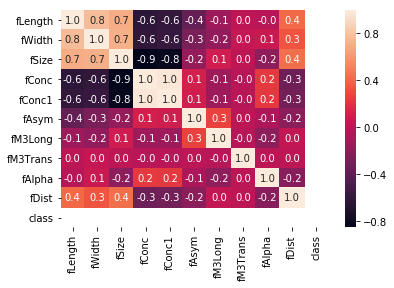

In [12]:
x = sns.heatmap(data.corr(), annot=True, fmt=".1f")

The 'fConc1' labeled feature vector was redundant with 'fConc' hence one of them was dropped.

In [79]:
data = data.drop(columns='fConc')
data.head()

,fLength,fWidth,fSize,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [80]:
prev = len(data)
data.drop_duplicates(inplace=True)
curr = len(data)
print("No of duplicate rows removed : {:,}".format(prev-curr))

No of duplicate rows removed : 115


Slicing class attribute and setting that as target feature.

In [35]:
#Separating vectors and labels
labels = data['class']
samples = data[data.columns[:-1]]

## Initialisation

Splitting data for train, test and CV

In [36]:
X, test_samples, Y, test_labels = train_test_split(samples, labels, test_size=0.1, random_state=0)

#Printing Stats
print("Training examples: {:}\tTesting examples: {:}\t".format(len(Y), len(test_labels)))

Training examples: 17014	Testing examples: 1891	


In [37]:
scaler= preprocessing.StandardScaler().fit(X)

In [38]:
X_scaled = scaler.transform(X)

In [39]:
test_samples_scaled = scaler.transform(test_samples)

# Classifying using SVM

In [40]:
Penaltypowers = [i for i in range(-3,9)]
parameters = {'C':[2**i for i in Penaltypowers]}
         
#BUILDING MODEL STRUCTURE
clf = svm.SVC(kernel='rbf', gamma = 'scale', probability=True)
model = RandomizedSearchCV(clf, parameters, cv=3, verbose=2, n_jobs=-1)

model.fit(X, np.ravel(Y))
print("\tModel trained: OK")

svm_model = model.best_estimator_

accuracy = accuracy_score(test_labels, svm_model.predict(test_samples))
F1 = f1_score(test_labels, svm_model.predict(test_samples), average='macro')    
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.0min finished


	Model trained: OK
	Accuracy = 0.8392384981491274	F1 score = 0.8034405696169638


# Classifying using Decision Tree

In [41]:
decision_grid={'min_samples_split' : range(2,1000,20),'max_depth': range(1,20,2)}

#BUILDING MODEL STRUCTURE
clf_tree = tree.DecisionTreeClassifier()
model = RandomizedSearchCV(clf_tree, decision_grid, verbose=2, cv=3, n_jobs=-1)

model.fit(X, np.ravel(Y))
print("\tModel trained: OK")

dt_model = model.best_estimator_

accuracy = accuracy_score(test_labels, dt_model.predict(test_samples))
F1 = f1_score(test_labels, dt_model.predict(test_samples), average='macro')    
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


	Model trained: OK
	Accuracy = 0.85193019566367	F1 score = 0.829565938423823


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


# Classifying using RandomForest

Defining parameters and variables

In [42]:
# Number of trees in random forest
n_estimators = [600, 800]
# Number of features to consider at every split
max_features = ['sqrt','auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(110, 140, num = 4)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth
              }

Building, training and evaluating model

In [43]:
clf = RandomForestClassifier()
model = RandomizedSearchCV(clf, random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

model.fit(X, np.ravel(Y))
print("\tModel trained: OK")

print("\tCalculating Scores...")
rf_model = model.best_estimator_

accuracy = accuracy_score(test_labels, rf_model.predict(test_samples))
F1 = f1_score(test_labels, rf_model.predict(test_samples), average='macro')
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.2min finished


	Model trained: OK
	Calculating Scores...
	Accuracy = 0.886832363828662	F1 score = 0.870307436312918


# ROC

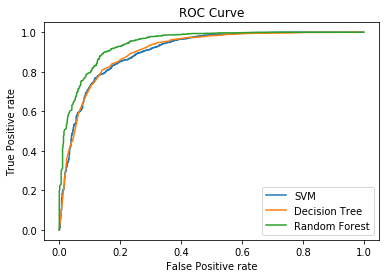

In [44]:
svm_probs = svm_model.predict_proba(test_samples)[:, label_encoder('g')]
dt_probs = dt_model.predict_proba(test_samples)[:, label_encoder('g')]
rf_probs = rf_model.predict_proba(test_samples)[:, label_encoder('g')]

svm_fpr, svm_tpr, _ = roc_curve(test_labels, svm_probs)
dt_fpr, dt_tpr, _ = roc_curve(test_labels, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_labels, rf_probs)

plt.plot(svm_fpr, svm_tpr, label='SVM')
plt.plot(dt_fpr, dt_tpr, label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')

plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')

plt.title("ROC Curve")
plt.legend()
#plt.savefig('ROC.png')

In [45]:
print("Area under the curve:\nSVM:{0:}\tDecision Tree:{1:}\tRandom Forest:{2:}".format(
    roc_auc_score(test_labels, svm_probs),
    roc_auc_score(test_labels, dt_probs),
    roc_auc_score(test_labels, rf_probs)
))

Area under the curve:
SVM:0.9060750210594124	Decision Tree:0.9076352757544224	Random Forest:0.9433904415043853


# Confusion Matrix

In [56]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    title = 'Confusion matrix'
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [68]:
def plot_cm(cm, s):
    title = 'Confusion matrix '+s
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

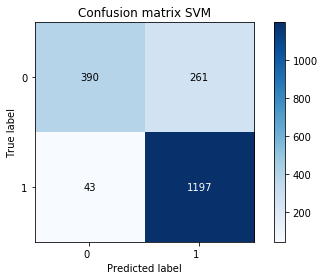

In [69]:
cm = confusion_matrix(test_labels, svm_model.predict(test_samples))
plot_cm(cm, 'SVM')

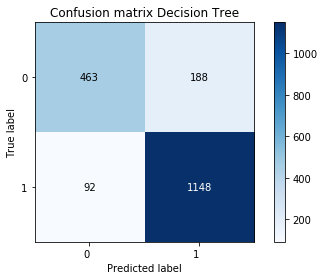

In [70]:
cm = confusion_matrix(test_labels, dt_model.predict(test_samples))
plot_cm(cm, 'Decision Tree')

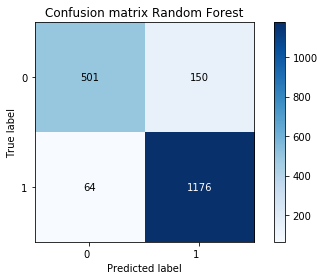

In [71]:
cm = confusion_matrix(test_labels, rf_model.predict(test_samples))
plot_cm(cm, 'Random Forest')